**Author:** C Mitchell

We want to quantify the uncertainty in our discrete PIC protocol, from sampling collection through to ICPMS result processing.

The N data (the non calcifying *C leptoporus* strain) are like a control because they are non calcifying, and in a perfect world, these PIC samples would all be zero. Thus, the PIC values for this culture give us a measure of the uncertainty of the overall protocol. 

**How do we synthesize this into an uncertainty measure?**

Some initial thoughts / steps (note in the below we are considering all the N data as one dataset, irrespective of filter protocol, because we've already shown the filter protocol doesn't make a difference):

1) Identify any outliers (e.g. the first sample run for this culture could have had some remnants from the previous sample if the filter tower was not well rinsed)
2) Calculate the mean and median and see if it is significantly different from 0
3) Look at variability of the N data
   

# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
fulldf = pd.read_csv('data/03-PIC-blank-corrected.csv')
fulldf = fulldf.assign(label= fulldf.Code.str[:-1])
fulldf = fulldf.assign(culture_id = fulldf.label.str[0])
fulldf = fulldf.assign(treatment_id = fulldf.label.str[1:])

Pulling out only the data from the N culture

In [3]:
Ndf = fulldf.loc[fulldf['culture_id'] == 'N']

# Identifying outliers

## Using boxplots

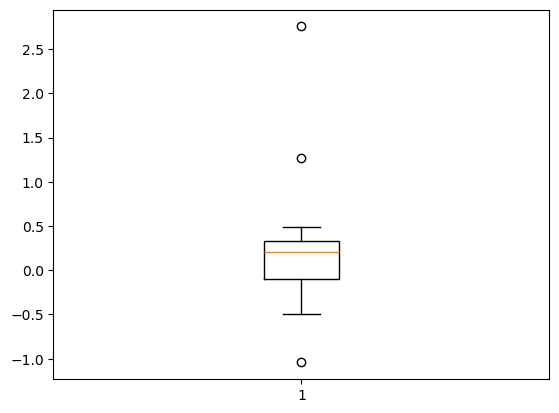

In [4]:
bx = plt.boxplot(Ndf['PIC ug/l']);

In [5]:
flier_values = bx['fliers'][0].get_ydata()
fliers = []
for ff in flier_values:
    fliers += [Ndf.loc[Ndf['PIC ug/l'] == ff,['Code','PIC ug/l']]]
fliers = pd.concat(fliers)

In [6]:
fliers

,Code,PIC ug/l
8,NAX2,-1.042525
9,NAX3,2.756807
56,NBY1,1.274060


# Exploring the median and mean of the dataset

## Mean

Using a one-sample t-test
- Null hypothesis: the mean PIC value is 0
- Alternative hyp: the mean PIC is not equal to 0

First, let's list the outliers

In [10]:
bx_outliers = [8, 9, 56]

Then do the t-test with outlier removed

In [11]:
stats.ttest_1samp(Ndf[~Ndf.index.isin(bx_outliers)]['PIC ug/l'],0)

TtestResult(statistic=np.float64(0.7578081991415596), pvalue=np.float64(0.4679430156602735), df=np.int64(9))

The p-value is not < 0.05, thus we cannot reject the null hypothesis and **the mean is not significantly different from 0**

## Median

Using a one-sample Wilcoxon signed-rank test
- Null hypothesis: the median PIC value is 0
- Alternative hyp: the median PIC is not equal to 0

Again, we'll do the test with outliers removed

In [12]:
stats.wilcoxon(Ndf[~Ndf.index.isin(bx_outliers)]['PIC ug/l'] - 0)

WilcoxonResult(statistic=np.float64(20.0), pvalue=np.float64(0.4921875))

The p-value is not < 0.05, thus we cannot reject the null hypothesis and **the median is not significantly different from 0**

# Variability of the PIC data (in the N culture)

In [14]:
pic = Ndf['PIC ug/l']
pic_bx = pic[~pic.index.isin(bx_outliers)]
pic2 = Ndf['PIC mmol/m3']
pic2_bx = pic2[~pic2.index.isin(bx_outliers)]

In [15]:
def stats_dict(pic):

    madfn = lambda x: np.median(np.abs(x - np.median(x)))
    maefn = lambda x: np.mean(np.abs(x - np.mean(x)))
    mapefn = lambda x: np.mean(np.abs((x - np.mean(x))/x))
    biasfn = lambda x: np.median(x - np.median(x))
    biasfn_mn = lambda x: np.mean(x - np.mean(x))
   
    pic_stats = {'mean' : np.mean(pic),
                 'median' : np.median(pic),
                 'std' : np.std(pic),
                 'ste' : np.std(pic)/len(pic),
                 'mad' : madfn(pic),
                 'mae' : maefn(pic),
                 'mape' : mapefn(pic),
                 'bias' : biasfn(pic),
                 'bias_mean' : biasfn_mn(pic),
                'n' : len(pic)}
    
    return pic_stats

Summary stats for the N culture PIC data with the outliers removed

In [18]:
statsdf = pd.DataFrame({ 
 'PIC ug/l' : stats_dict(pic_bx), 
 'PIC mmol/m3' : stats_dict(pic2_bx)})

pd.options.display.float_format = '{:.4f}'.format

statsdf

,PIC ug/l,PIC mmol/m3
mean,0.0726,0.0061
median,0.1311,0.0109
std,0.2875,0.0240
ste,0.0288,0.0024
mad,0.1745,0.0145
mae,0.2414,0.0201
mape,1.2924,1.2924
bias,0.0000,0.0000
bias_mean,0.0000,-0.0000
n,10.0000,10.0000


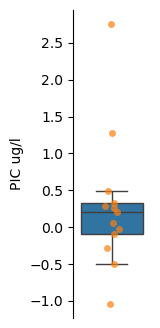

In [19]:
plt.figure(figsize = (1,4))
sns.boxplot(pic,showfliers=False)
sns.stripplot(pic,alpha =0.7, jitter = True)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([]);

For reference (from Sunny), the following shows the distribution of discrete PIC values in the Balch Lab database, note these are in mol/m3 and the above are in mmol/m3:

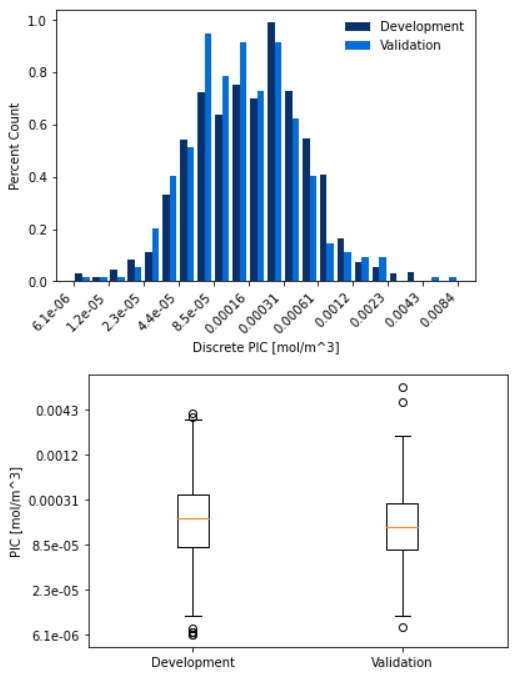

In [23]:
from IPython.display import Image
Image('images/discrete_pic_balch_database_plots.png')

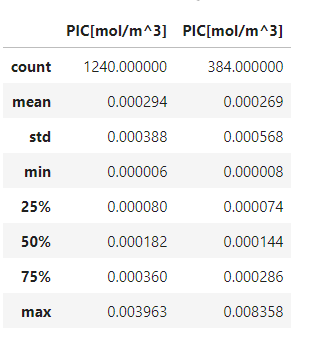

In [25]:
Image('images/discrete_pic_balch_database_numbers.png')

I think we want to report the standard deviation, mad and mae using the boxplot outlier removal method, as our overall method uncertainty.

### Comparison with the full Balch lab discrete PIC dataset

In [55]:
balchdbfile = '/mnt/storage/labs/mitchell/projects/pic-algorithm/pic-algorithm-dev-GH-repo-data/01-field-data/02b-discrete-formatted.csv'
balchdb = pd.read_csv(balchdbfile, low_memory=False, na_values = -999)

In [56]:
db_pic = pd.DataFrame({'PIC[ug/L]' : balchdb['PIC[ug/L]']})
db_pic['PIC[mmol/m3]'] = db_pic['PIC[ug/L]'] / 12

In [57]:
print('percentile of data below std: ' + str(np.sum(db_pic['PIC[mmol/m3]'] < statsdf.loc['std','boxplot removed mmol/m3']) / len(db_pic) * 100))
print('percentile of data below mad: ' + str(np.sum(db_pic['PIC[mmol/m3]'] < statsdf.loc['mad','boxplot removed mmol/m3']) / len(db_pic) * 100))
print('percentile of data below mae: ' + str(np.sum(db_pic['PIC[mmol/m3]'] < statsdf.loc['mae','boxplot removed mmol/m3']) / len(db_pic) * 100))

percentile of data below std: 10.818088223647738
percentile of data below mad: 8.711491248911063
percentile of data below mae: 10.176605686227925


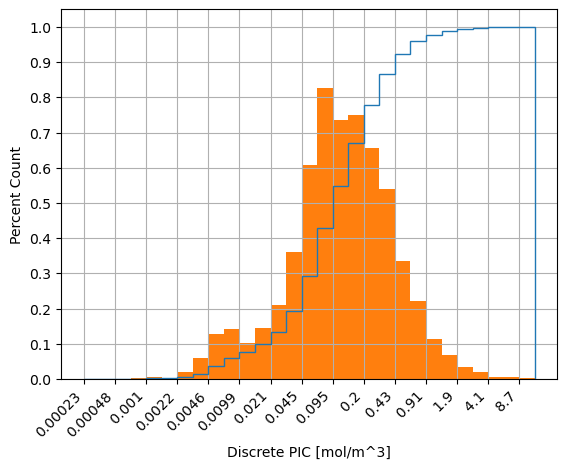

In [58]:
log_pic = np.log10(db_pic.loc[db_pic['PIC[mmol/m3]']>0, 'PIC[mmol/m3]'])
log_pic.dropna(inplace=True)

pic_bins = np.linspace(log_pic.min(), log_pic.max(), 30)

tick_positions = pic_bins[::2]
tick_values = [10**tic for tic in tick_positions]
tick_labels = ['{:6.2g}'.format(lab) for lab in tick_values]

plt.figure()
plt.hist(log_pic, pic_bins,density=True,cumulative=True,histtype='step')#, color=['#08306b',(0,0.427,0.859)], label=['Development','Validation'], density=True)
plt.hist(log_pic, pic_bins,density=True)
plt.xlabel('Discrete PIC [mol/m^3]')
plt.ylabel('Percent Count')
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
plt.tick_params(direction='out')
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]);
plt.grid()